# Acknowledgments:
This notebook was graciously provided by Enrico Foglia and Michaël Bauerheim from ISAE-SUPAERO, for which we are very grateful. Their contributions have been very valuable in enhancing the clearness of the approach and offering practical insights into ZigZag method. We extend our sincere thanks for their generous support and collaboration.


# ZigZag for OOD detection

## Methodology

### Anomaly detection preliminaries

Let the data generating process be defined as the joint probability $P(X,Y)$ over $\mathcal X\times \mathcal Y$ (the input and output space, respectively). From this we construct a training dataset $\mathcal D=\{(x_i,y_i)\sim P(X,Y)\}$ that we use to train a parametric model $f_\theta:\mathcal X\to\mathcal Y$. It is often the case, however, that at inference time the new samples come from a different marginal distribution $P'(X)\neq P(X)$ (_covariate shift_) which can present some anomalies, i.e. points $x\in \mathcal X$ that would appear very rarely (or never) in the training distribution. We thus define the set of anomalies:
$$
\mathcal A=\{x\in\mathcal X\;\vert\; p(x)<\tau\}
$$
where $\tau$ is a small positive threshold. Since the model $f_\theta$ might not be well calibrated for these datapoints, we wish to flag them to be able to treat them with particular care. However, the true marginal density $p(X)$ is unknown and in general very difficult to estimate for high dimensional input spaces, so we define a score function $u:\mathcal X\to \mathbb R$ that we expect to be related to $p$ as $u(x) = -T(p(x))$, where $T$ is a stictly increasing function. The set $\mathcal A$ can thus be rewritten as:
$$
\mathcal A = \{x\in\mathcal X\;\vert\; u(x)>\bar u\}
$$
for some appropriate $\bar u$ and $T$. The true challenge is to estimate $u$ and $\bar u$ in an unsupervised manner, i.e. having only access to data generated by $P(X)$.  


In [1]:
import torch
import torch.nn as nn

from torch import Tensor
import random
import numpy as np

# for reproducibility, admittedly this value gives a pretty catastrophic
# perfomance for the original zigzag, but serves as a point of departure for
# future discussions
def set_seed(seed_value):
    """ Set seed for reproducibility. """
    random.seed(seed_value)       # Python random module.
    np.random.seed(seed_value)    # Numpy module.
    torch.manual_seed(seed_value)

set_seed(0)

new_zz = False

K1 = 30
K2 = 20
K3 = 10

class ZigZag(nn.Module):
    def __init__(self, in_features: int, out_features: int, k) -> None:
        super().__init__()
        self.type = 'zigzag'
        self.out_features = out_features
        self.input = nn.Linear(in_features+out_features, K1)
        self.hidden1 = nn.Linear(K1, K2)
        self.hidden2 = nn.Linear(K2, K3)
        self.output = nn.Linear(K3, out_features)

        self.activation = nn.ReLU()

        self.k = k

    def forward(self, x: Tensor, y: Tensor = None) -> Tensor:
        if y is None:
            batch = x.shape[0]
            y = self.k*torch.ones((batch, self.out_features),device=x.device)

        x = torch.cat([x, y], dim=1)

        x = self.activation(self.input(x))
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        return self.output(x)

    def uncertainty(self, x: Tensor) -> Tensor:
        y1 = self.forward(x)
        if new_zz: return torch.abs(self.forward(x,y1)) # new zigzag
        else: return torch.abs(self.forward(x,y1)-y1) # original zigzag

    def call_recursively(self, x: Tensor) -> Tensor:
        y1 = self.forward(x)
        if new_zz: return y1+self.forward(x,y1) # new zigzag
        else: return self.forward(x,y1) # original zigzag


A non trivial question is how to define a dataset split into "_normal_" and "_anomalous_" samples based on a covariate shift $P'(X)\neq P(X)$. For a classification task it is routine to use as anomalies a set of images whose label is not in the training dataset. This type of dataset shift is sometimes referrend to as _semantic shift_, and is equivalent to set:
$$
\mathcal A=\{x\in \mathcal X\;\vert\; p(y\vert x) = 0\;\forall y\in\mathcal Y\}
$$
however, this definition is too stringent for regression tasks, where even anomalous examples can have outputs that lie within the training $\mathcal Y$. We thus propose to use a dataset where at least one of the covariates has a distinctively multimodal: by never showing one of the modes to the model during training we can be sure that $P_\text{test}(X)\neq P_\text{train}(X)$. For this purpuse all test will be conducted on the Boston Housing, Yacht, Power Plant and Energy datasets from the UCI database, which is a _de-facto_ standard of the uncertainty quantification community (see, for example, Lakshminarayanan2017, table 1).

In [2]:
# @title import dataset
# connect to drive to have the relevant modules
!wget https://raw.githubusercontent.com/cvlab-epfl/zigzag/main/exps/data/bostonHousing.txt

--2024-05-04 13:54:43--  https://raw.githubusercontent.com/cvlab-epfl/zigzag/main/exps/data/bostonHousing.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49082 (48K) [text/plain]
Saving to: ‘bostonHousing.txt’

bostonHousing.txt   100%[===================>]  47.93K  --.-KB/s    in 0.01s   

2024-05-04 13:54:43 (4.51 MB/s) - ‘bostonHousing.txt’ saved [49082/49082]



In [5]:
# @title dataset utilities
import os

from torch.utils.data import Dataset, Subset

import numpy as np
import matplotlib.pyplot as plt

def read_txt(fname: str) -> tuple:
    array = np.loadtxt(fname, dtype=float)
    x = array[:,:-1]
    y = array[:,-1]
    return torch.Tensor(x), torch.Tensor(y).unsqueeze(1)

def normalize(tensor: Tensor) -> tuple:
    mean = tensor.mean(dim=0)
    std = tensor.std(dim=0)
    normalized_tensor = tensor - mean
    return normalized_tensor / std, mean, std

class UCIDataset(Dataset):
    def __init__(self, fname: str) -> None:
        super(UCIDataset).__init__()
        x, y = read_txt(fname)
        self.x, self.x_mean, self.x_std = normalize(x)
        self.y, self.y_mean, self.y_std = normalize(y)

    def __len__(self) -> int:
        return self.x.shape[0]

    def __getitem__(self, index: int) -> tuple:
        return self.x[index], self.y[index]

    def corner_plot(self, fig_dir: str = None) -> None:
        n_vars = self.x.shape[1]

        fig, axs = plt.subplots(n_vars, n_vars, figsize=(10,10),layout='constrained')
        for i in range(n_vars):
            for j in range(n_vars):
                if i == j:
                    axs[i,j].hist(self.x[:,i], bins=15, color='skyblue', edgecolor='black',
                                  histtype='stepfilled')

                else:
                    if j<i:
                       pcm = axs[i,j].scatter(self.x[:,i], self.x[:,j], c=self.y , alpha=1.0,
                                        cmap='GnBu',s=5)
                    else:
                        axs[i,j].axis('off')
                if i<n_vars-1:
                    axs[i,j].xaxis.set_visible(False)
                if j > 0:
                    axs[i, j].yaxis.set_visible(False)
        for i in range(n_vars):
            axs[i,0].set_ylabel(f'var {i+1}')
            axs[-1,i].set_xlabel(f'var {i+1}')
            axs[-1,i].set_xlim(axs[-1,i].get_xlim())

        fig.colorbar(pcm, ax=axs[0:2,-1], label=r'$y$')

        if fig_dir is not None:
            plt.savefig(os.path.join(fig_dir,'corner_plot.png'), dpi=300)
        else: plt.show()

    def hist_single_var(self, idx:int, mask=None,fig_dir: str = None) -> None:
        fig,ax = plt.subplots()
        if idx == -1:
            var = self.y.T
            if mask is not None:
                var = var[:,mask]
        else:
            var = self.x[:,idx]
            if mask is not None:
                var = var[mask]


        ax.hist(var, bins='auto', color='skyblue', edgecolor='black', density=False,
                        histtype='stepfilled')

        ax.set_ylabel(r'counts')
        if fig_dir is not None:
            plt.savefig(os.path.join(fig_dir, 'y_hist.png'), dpi=160)
        else: plt.show()

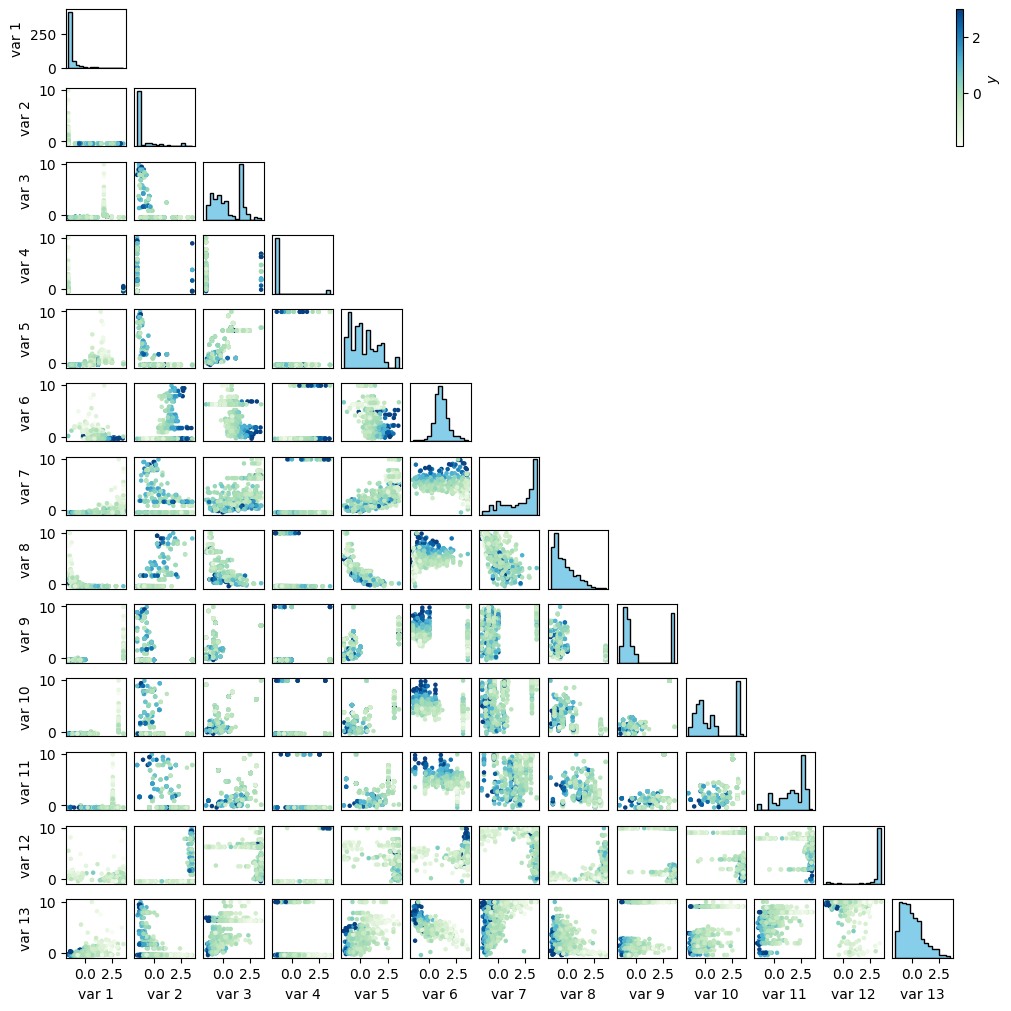

In [4]:
dataset = UCIDataset("/content/bostonHousing.txt")
dataset.corner_plot() # plotting the corner plot can take some time for large datasets

From the corner plot above it is easy to see that for the `bostonHousing` dataset the variable 9 is bimodal. We thus split the dataset in `id` and `ood` by separating the two modes, around $x_9 = 0.5$.

number of id samples : 374
number of ood samples: 132


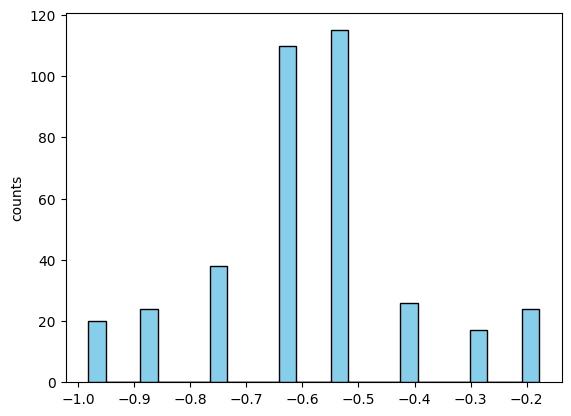

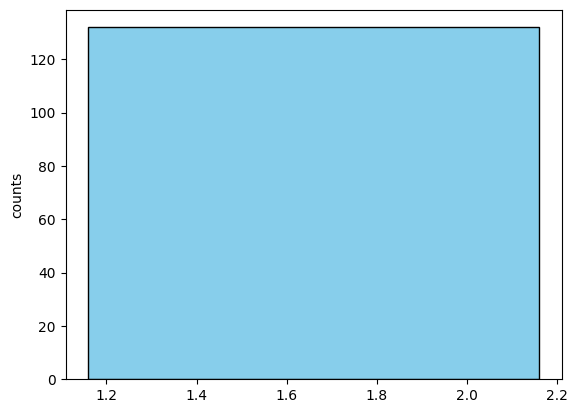

In [6]:
from torch.utils.data import random_split, DataLoader, Dataset

def split_by_single_variable(dataset: Dataset, var_idx: int, interval: list) -> tuple:
    var = dataset.x[:,var_idx]
    train_cond = (var > interval[0]) * (var < interval[1])

    train_idx = torch.nonzero(train_cond).squeeze()
    test_idx = torch.nonzero( ~train_cond).squeeze()
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

var = 8 # index: START FROM 0!

id_data, ood_data = split_by_single_variable(dataset, var, [-10.,0.5 ]) # adjust the parameters depending on the dataset
print(f'number of id samples : {len(id_data)}')
print(f'number of ood samples: {len(ood_data)}')

N_split = int(0.9 * len(id_data))
train_data, test_data = Subset(id_data, range(N_split)),  Subset(id_data, range(N_split, len(id_data))) #random_split(id_data, [0.9, 0.1])
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

id_data.dataset.hist_single_var(var, mask=id_data.indices)
ood_data.dataset.hist_single_var(var, mask=ood_data.indices)

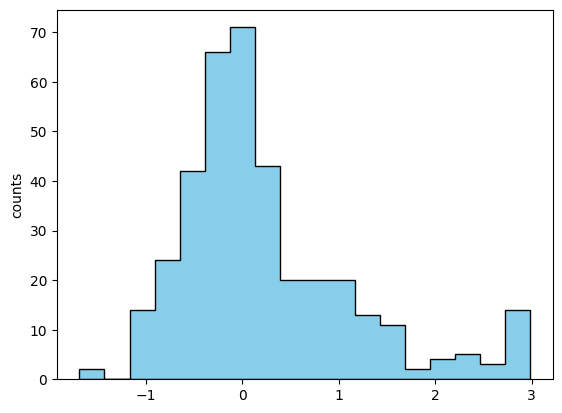

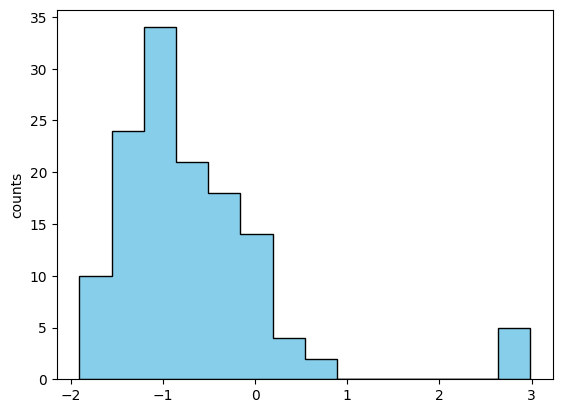

Histograms for the outputs variable for the ID dataset (top) and the OOD one (bottom)


In [7]:
id_data.dataset.hist_single_var(-1, mask=id_data.indices)
ood_data.dataset.hist_single_var(-1, mask=ood_data.indices)

print('Histograms for the outputs variable for the ID dataset (top) and the OOD one (bottom)')

Notice that, even though an important part of the distribution has been removed, the outputs of the ID and OOD datasets still share some important similarities. It would be hard to separate them _a posteriori_ by just looking at the $y$.

The competitors for the ood detection task at hand are Deep Ensembles and MC Dropout, where we use their predicted epistemic variance as the uncertainty score $u$.

In [8]:
class SingleMLP(nn.Module):
    def __init__(self, in_features, out_features) -> None:
        super().__init__()
        self.type = 'simple_mlp'
        self.out_features = out_features
        self.input = nn.Linear(in_features, K1)
        self.hidden1 = nn.Linear(K1, K2)
        self.hidden2 = nn.Linear(K2, K3)
        self.output = nn.Linear(K3, out_features)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.input(x))
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        return self.output(x)

class Ensemble():
    def __init__(self, n_models:int, in_features:int, out_features:int):
        self.model_list = []
        self.type = 'ensemble'
        for i in range(n_models):
            self.model_list.append(SingleMLP(in_features, out_features))

    def __call__(self, x):
        y_list = []
        for model in self.model_list:
            y_list.append(model(x))

        return torch.stack(y_list).mean(dim=0)

    def uncertainty(self, x):
        y_list = []
        for model in self.model_list:
            y_list.append(model(x))
        return torch.stack(y_list).var(dim=0)

    def cpu(self):
        for model in self.model_list:
            model.cpu()

class MCDropout(nn.Module):
    def __init__(self, in_features, out_features, p=0.2) -> None:
        super().__init__()
        self.type = 'dropout'
        self.out_features = out_features
        self.input = nn.Linear(in_features, K1)
        self.hidden1 = nn.Linear(K1, K2)
        self.hidden2 = nn.Linear(K2, K3)
        self.output = nn.Linear(K3, out_features)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=p)

    def forward(self, x):
        x = self.activation(self.input(x))
        x = self.dropout(x)
        x = self.activation(self.hidden1(x))
        x = self.dropout(x)
        x = self.activation(self.hidden2(x))
        x = self.dropout(x)
        return self.output(x)

    def uncertainty(self, x, T):
        self.train()
        N = x.shape[0]
        preds = torch.zeros(T,N)
        for t in range(T):
            preds[t,:] = self.forward(x).squeeze()
        return torch.var(preds, dim=0).unsqueeze(1)


new_zz = False

K1 = 30
K2 = 20
K3 = 10

import torch.nn.init as init

class ZigZag(nn.Module):
    def __init__(self, in_features: int, out_features: int, k) -> None:
        super().__init__()
        self.type = 'zigzag'
        self.out_features = out_features
        self.input = nn.Linear(in_features+out_features, K1)
        self.hidden1 = nn.Linear(K1, K2)
        self.hidden2 = nn.Linear(K2, K3)
        self.output = nn.Linear(K3, out_features)

        self.activation = nn.ReLU()

        self.k = k

        self.init_weights()

    def forward(self, x: Tensor, y: Tensor = None) -> Tensor:
        if y is None:
            batch = x.shape[0]
            # y = torch.zeros((batch, self.out_features),device=x.device)
            y = self.k*torch.ones((batch, self.out_features),device=x.device)

        x = torch.cat([x, y], dim=1)

        x = self.activation(self.input(x))
        x = self.activation(self.hidden1(x))
        x = self.activation(self.hidden2(x))
        return self.output(x)

    def init_weights(self):
        # Set the standard deviation for the initialization
        std_dev = 0.01  # This can be adjusted to increase the variance

        # Initialize weights for each linear layer
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # Use a normal distribution with a higher standard deviation
                # init.normal_(m.weight, mean=0.0, std=std_dev)
                if m.bias is not None:
                    init.constant_(m.bias, 0)  # Initialize biases to zero

    def uncertainty(self, x: Tensor) -> Tensor:
        y1 = self.forward(x)
        if new_zz: return torch.abs(self.forward(x,y1)) # new zigzag
        else: return torch.abs(self.forward(x,y1)-y1) # original zigzag

    def call_recursively(self, x: Tensor) -> Tensor:
        y1 = self.forward(x)
        if new_zz: return y1+self.forward(x,y1) # new zigzag
        else: return self.forward(x,y1) # original zigzag

In [12]:
in_features = 13
out_features = 1
n_models = 5
p = 0.2 # dropout probability

zigzag = ZigZag(in_features, out_features, k=50)
ensemble = Ensemble(n_models, in_features, out_features)
dropout = MCDropout(in_features, out_features, p)

For fairness, all models are trained in the exact same way

In [11]:
# @title training utilities
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm

def get_available_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def mean(lst: list) -> float:
    return sum(lst)/len(lst)

def train_epoch(model, dataset, optimizer, loss_fn, device):
    model.train()
    current_loss = 0.0
    for batch in dataset:
        x,y = batch
        x = x.to(device)
        y = y.to(device)

        if model.type == 'simple_mlp' or model.type == 'dropout':
            pred = model(x)
            loss = loss_fn(pred, y)

        elif model.type == 'zigzag':
            pred0 = model(x)
            pred1 = model(x,y )
            if new_zz: loss = loss_fn(pred0,y) + loss_fn(pred1, torch.zeros_like(y)) # new zigzag
            else: loss = loss_fn(pred0,y) + loss_fn(pred1, y) # original zigzag

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_loss += loss.item()

    return current_loss / len(dataset), loss

def test_epoch(model, dataset, metrics, device):
    model.eval()
    with torch.no_grad():
        res_list = [0. for metric in metrics]
        N = len(dataset)
        for batch in dataset:
            x,y = batch
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            for i, metric in enumerate(metrics):
                res_list[i] += metric(pred, y)/N
    return res_list

def plot_history(training_history, test_history, model_type, fig_dir=None):
    if model_type == 'ensemble':
        epochs = len(training_history[0])
        test_history = torch.Tensor(test_history)
        training_history = torch.Tensor(training_history)
    else:
        epochs = len(training_history)
        test_history = torch.Tensor(test_history).unsqueeze(0)
        training_history = torch.Tensor(training_history).unsqueeze(0)

    fig, ax = plt.subplots()
    for i in range(training_history.shape[0]):
        # 1) train / test
        ax.semilogy(range(1, epochs+1), training_history[i],
                    color='tab:blue',linewidth=1, alpha=0.5)
        ax.semilogy(range(1, epochs+1), test_history[i,:,0],
                    color='black',linewidth=1, alpha=0.5)
    ax.semilogy(range(1, epochs+1), training_history.mean(dim=0), color='tab:blue', label='Training')
    ax.semilogy(range(1, epochs+1), test_history.mean(dim=0)[:,0], 'k--', label='Test')
    ax.set_xlim([1,epochs])
    ax.set_xlabel(r'epoch')
    ax.set_ylabel(r'$\ell$')
    ax.set_title(f'Training history; {model_type}')
    ax.legend()
    if fig_dir is not None:
        fname = os.path.join(fig_dir, f'training_history_{model_type}.png')
        plt.savefig(fname, dpi=160)
    else: plt.show()

    # 2) test metrics
    n_metrics = test_history.shape[2]
    fig, axs = plt.subplots(1, n_metrics, layout='constrained')
    if n_metrics == 1:
        for i in range(training_history.shape[0]):
            axs.semilogy(range(1,epochs+1), test_history[i,:],
                         color='tab:blue',linewidth=1, alpha=0.5)
        axs.semilogy(range(1,epochs+1), test_history.mean(dim=0)[:], color='tab:blue')
        axs.set_xlim([1,epochs])
        axs.set_xlabel('epoch')
        axs.set_title(f'Metric')
        axs.set_ylabel('metric')
    else:
        for i in range(n_metrics):
            axs[i].semilogy(range(1,epochs+1), test_history[:,i])
            axs[i].set_xlim([1,epochs])
            axs[i].set_xlabel('epoch')
            axs[i].set_title(f'Metric {i+1}')
        axs[0].set_ylabel('metric')
    if fig_dir is not None:
        fname = os.path.join(fig_dir, f'test_history_{model_type}.png')
        plt.savefig(fname, dpi=160)
    else: plt.show()


def train_model(model, train_data, test_data, optimizer, loss_fn, metrics, epochs, fig_dir=None):
    print('+---------------------+')
    print('|   Training start    |')
    print('+---------------------+')

    device = get_available_device()
    model.to(device)

    training_history = []
    testing_history = []
    lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
    for epoch in tqdm(range(epochs)):
        current_loss, train_loss = train_epoch(model, train_data, optimizer, loss_fn,
                                               device)
        training_history.append(current_loss)
        testing_history.append(test_epoch(model, test_data, metrics, device))
        lr_scheduler.step(train_loss)

    print('\n')
    print('+---------------------+')
    print('|   Training ended    |')
    print('+---------------------+')

    plot_history(training_history, testing_history, model.type, fig_dir)

    return model

def train_ensemble(ensemble, train_data, test_data, lr, loss_fn, metrics, epochs, fig_dir=None):
    print('+---------------------+')
    print('|   Training start    |')
    print('+---------------------+')
    training_history_list = []
    testing_history_list = []
    device = get_available_device()

    for model in ensemble.model_list:
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
        training_history = []
        testing_history = []
        for epoch in tqdm(range(epochs)):
            current_loss, train_loss = train_epoch(model, train_data, optimizer, loss_fn,
                                                   device)
            training_history.append(current_loss)
            testing_history.append(test_epoch(model, test_data, metrics,device))
            lr_scheduler.step(train_loss)
        training_history_list.append(training_history)
        testing_history_list.append(testing_history)

    print('\n')
    print('+---------------------+')
    print('|   Training ended    |')
    print('+---------------------+')

    plot_history(training_history_list, testing_history_list, ensemble.type, fig_dir)

    return ensemble

+---------------------+
|   Training start    |
+---------------------+


100%|██████████| 40/40 [00:04<00:00,  9.88it/s]




+---------------------+
|   Training ended    |
+---------------------+


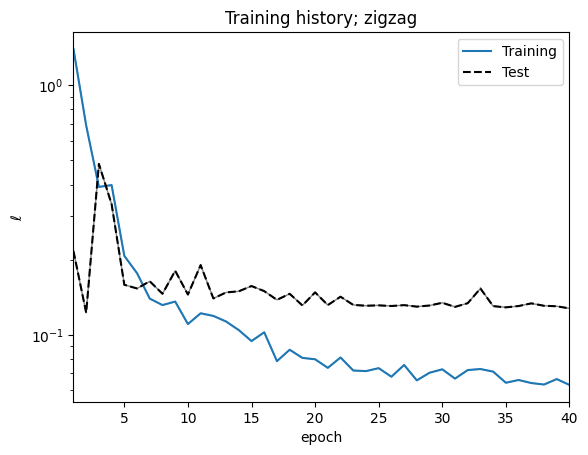

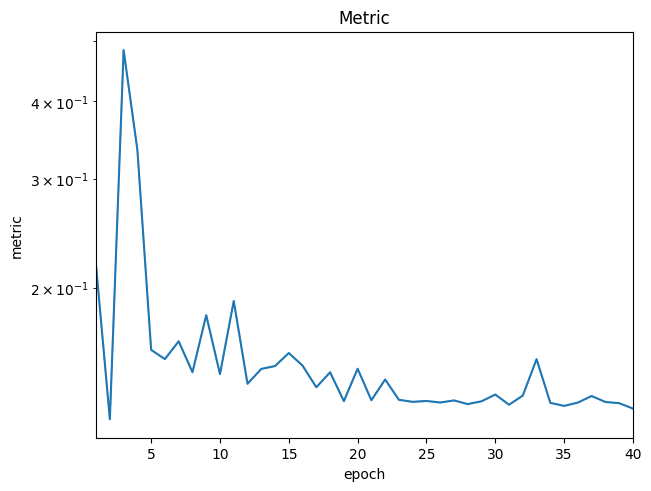

+---------------------+
|   Training start    |
+---------------------+


100%|██████████| 40/40 [00:01<00:00, 23.63it/s]




+---------------------+
|   Training ended    |
+---------------------+


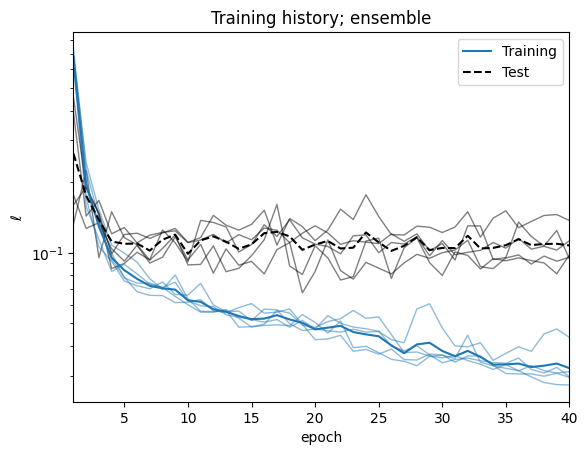

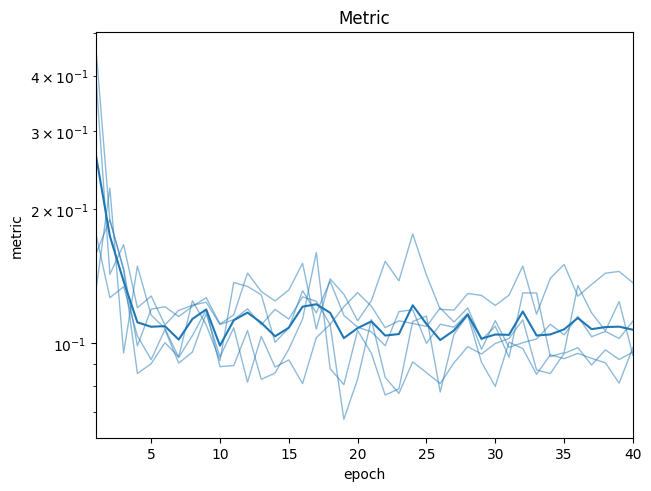

+---------------------+
|   Training start    |
+---------------------+


100%|██████████| 40/40 [00:01<00:00, 22.54it/s]




+---------------------+
|   Training ended    |
+---------------------+


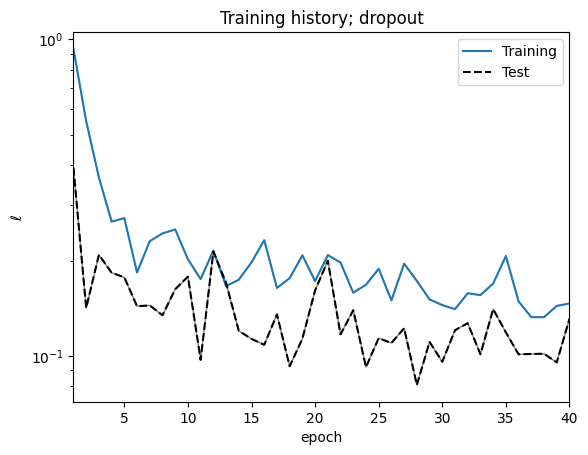

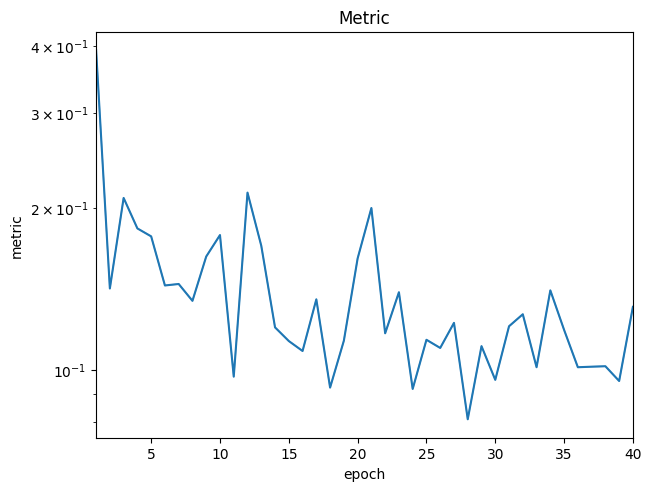

In [23]:
set_seed(7)

in_features = 13
out_features = 1
n_models = 5
p = 0.2 # dropout probability

zigzag = ZigZag(in_features, out_features, k=50)
ensemble = Ensemble(n_models, in_features, out_features)
dropout = MCDropout(in_features, out_features, p)

lr = 1e-2
epochs = 40
metrics = [nn.MSELoss()]

optimizer = torch.optim.Adam(zigzag.parameters(), lr=lr)
loss_fn = nn.MSELoss()

zigzag = train_model(zigzag, train_loader, test_loader,
                    optimizer, loss_fn, metrics, epochs)

ensemble = train_ensemble(ensemble, train_loader, test_loader,
                    lr, loss_fn, metrics, epochs)

optimizer = torch.optim.Adam(dropout.parameters(), lr=lr)
dropout = train_model(dropout, train_loader, test_loader,
                    optimizer, loss_fn, metrics, epochs)

Check that the models are fitted correctly.

In [24]:
from sklearn.metrics import r2_score

zigzag.cpu()
ensemble.cpu()
dropout.cpu()

x_train, y_train = train_data[:]
x_test, y_test = test_data[:]
x_ood, y_ood = ood_data[:]
with torch.no_grad():
    pred_train_zz = zigzag.call_recursively(x_train)
    pred_test_zz = zigzag.call_recursively(x_test)
    pred_ood_zz = zigzag.call_recursively(x_ood)

    pred_train_ens = ensemble(x_train)
    pred_test_ens  = ensemble(x_test)
    pred_ood_ens  = ensemble(x_ood)

    dropout.eval()
    pred_train_drop = dropout(x_train)
    pred_test_drop = dropout(x_test)
    pred_ood_drop = dropout(x_ood)

def mae_score(pred, y_gt):
    return torch.abs(y_gt - pred).mean()

print( '+----------------------------------------------+')
print(f'| Model    | r2 train  | r2 test   | r2 ood    |')
print( '+----------------------------------------------+')
print(f'| Ensemble | {r2_score(y_train, pred_train_ens):>9.4f} | {r2_score(y_test, pred_test_ens):>9.4f} | {r2_score(y_ood, pred_ood_ens):>9.4f} |')
print(f'| Dropout  | {r2_score(y_train, pred_train_drop):>9.4f} | {r2_score(y_test, pred_test_drop):>9.4f} | {r2_score(y_ood, pred_ood_drop):>9.4f} |')
print(f'| ZigZag   | {r2_score(y_train, pred_train_zz):>9.4f} | {r2_score(y_test, pred_test_zz):>9.4f} | {r2_score(y_ood, pred_ood_zz):>9.4f} |')
print( '+----------------------------------------------+')

print( '+----------------------------------------------+')
print(f'| Model    | mae train  | mae test   | mae ood    |')
print( '+----------------------------------------------+')
print(f'| Ensemble | {mae_score(y_train, pred_train_ens):>9.4f} | {mae_score(y_test, pred_test_ens):>9.4f} | {mae_score(y_ood, pred_ood_ens):>9.4f} |')
print(f'| Dropout  | {mae_score(y_train, pred_train_drop):>9.4f} | {mae_score(y_test, pred_test_drop):>9.4f} | {mae_score(y_ood, pred_ood_drop):>9.4f} |')
print(f'| ZigZag   | {mae_score(y_train, pred_train_zz):>9.4f} | {mae_score(y_test, pred_test_zz):>9.4f} | {mae_score(y_ood, pred_ood_zz):>9.4f} |')
print( '+----------------------------------------------+')

+----------------------------------------------+
| Model    | r2 train  | r2 test   | r2 ood    |
+----------------------------------------------+
| Ensemble |    0.9686 |    0.7027 |    0.2639 |
| Dropout  |    0.9162 |    0.6016 |   -0.4150 |
| ZigZag   |    0.9289 |    0.6750 |   -0.0483 |
+----------------------------------------------+
+----------------------------------------------+
| Model    | mae train  | mae test   | mae ood    |
+----------------------------------------------+
| Ensemble |    0.1182 |    0.2459 |    0.5435 |
| Dropout  |    0.2102 |    0.2691 |    0.7781 |
| ZigZag   |    0.1803 |    0.2406 |    0.7179 |
+----------------------------------------------+


Being the task a binary classification one, the most relevant metrics are the receiver-operator-characteristic (ROC) curve and the precision-recall (PR) one, and the area beneath them (AUC).

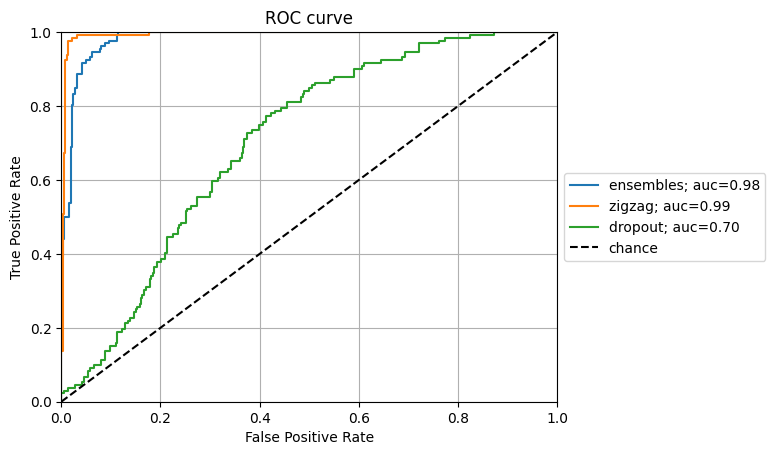

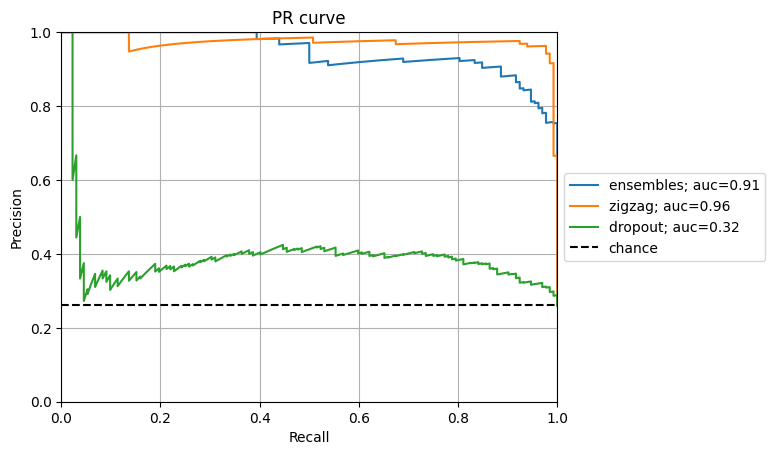

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from scipy.integrate import simpson
T = 5 # number of dropout evaluations

with torch.no_grad():

    u_train_zz = zigzag.uncertainty(x_train)
    u_test_zz  = zigzag.uncertainty(x_test)
    u_ood_zz   = zigzag.uncertainty(x_ood)
    u_zz       = zigzag.uncertainty(dataset.x)

    u_train_ens = ensemble.uncertainty(x_train)
    u_test_ens  = ensemble.uncertainty(x_test)
    u_ood_ens   = ensemble.uncertainty(x_ood)
    u_ens       = ensemble.uncertainty(dataset.x)

    dropout.eval()
    u_train_drop = dropout.uncertainty(x_train, T)
    u_test_drop  = dropout.uncertainty(x_test, T)
    u_ood_drop   = dropout.uncertainty(x_ood, T)
    u_drop       = dropout.uncertainty(dataset.x, T)

def pr_auc_score(target, pred):
    p,r,_ = precision_recall_curve(target, pred)
    return simpson(p[::-1],r[::-1])

target = torch.zeros_like(dataset.y)
target[ood_data.indices] = 1

# roc
fpr_ens, tpr_ens, _ = roc_curve(target, u_ens)
fpr_zz, tpr_zz, _ = roc_curve(target, u_zz)
fpr_drop, tpr_drop, _ = roc_curve(target, u_drop)

# pr
p_ens, r_ens, _ = precision_recall_curve(target, u_ens)
p_zz, r_zz, _ = precision_recall_curve(target, u_zz)
p_drop, r_drop, _ = precision_recall_curve(target, u_drop)

auc_ens = roc_auc_score(target, u_ens)
auc_zz = roc_auc_score(target, u_zz)
auc_drop = roc_auc_score(target, u_drop)

pr_auc_ens = pr_auc_score(target, u_ens)
pr_auc_zz = pr_auc_score(target, u_zz)
pr_auc_drop = pr_auc_score(target, u_drop)

fig, ax = plt.subplots()
ax.plot(fpr_ens, tpr_ens, label=f'ensembles; auc={auc_ens:.2f}')
ax.plot(fpr_zz, tpr_zz, label=f'zigzag; auc={auc_zz:.2f}')
ax.plot(fpr_drop, tpr_drop, label=f'dropout; auc={auc_drop:.2f}')
ax.plot([0,1],[0,1], 'k--', label='chance')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('ROC curve')
plt.grid()
plt.show()

chance = x_ood.shape[0]/(x_train.shape[0]+x_test.shape[0]+x_ood.shape[0])
fig, ax = plt.subplots()
ax.plot(r_ens, p_ens, label=f'ensembles; auc={pr_auc_ens:.2f}')
ax.plot(r_zz, p_zz, label=f'zigzag; auc={pr_auc_zz:.2f}')
ax.plot(r_drop, p_drop, label=f'dropout; auc={pr_auc_drop:.2f}')
ax.hlines(chance, 0,1, ls='--', color='k', label='chance')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('PR curve')
plt.grid()
plt.show()


